# Ridge & Lasso Regression — Live Class Notebook
**Topics:** Linear Regression → Overfitting Problem → Ridge (L2) → Lasso (L1) → Comparison

---
### How to use this notebook:
- We will run each cell **together** step by step
- **Read the comments** — they explain what each line does
- **Don't skip cells** — later cells depend on earlier ones
---

## Section 1: Import Libraries
These are all the tools we need today.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Settings
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print('✅ All libraries loaded successfully!')

✅ All libraries loaded successfully!


## Section 2: Create Our Dataset

We'll create a **House Price** dataset with features like size, bedrooms, age, etc.  
This is synthetic data so we can control everything and see clearly what's happening.

In [2]:
# Set random seed for reproducibility (everyone gets same results)
np.random.seed(42)
n = 200  # 200 houses

# Create meaningful features
size_sqft = np.random.normal(1500, 500, n)          # House size in sqft
bedrooms = np.random.randint(1, 6, n)               # 1 to 5 bedrooms
age_years = np.random.normal(20, 10, n)             # Age of house
distance_city = np.random.normal(10, 5, n)          # Distance from city center (km)
garage_size = np.random.randint(0, 4, n)            # 0 to 3 car garage

# Create NOISY/IRRELEVANT features (these should NOT matter)
random_noise_1 = np.random.normal(0, 1, n)          # Pure noise
random_noise_2 = np.random.normal(0, 1, n)          # Pure noise
random_noise_3 = np.random.normal(0, 1, n)          # Pure noise
day_of_week = np.random.randint(1, 8, n)            # Day listed (irrelevant)
lucky_number = np.random.randint(1, 100, n)         # Totally irrelevant

# Generate house price (only depends on REAL features, not noise)
price = (
    150 * size_sqft +                  # Bigger house = higher price
    20000 * bedrooms +                  # More bedrooms = higher price
    -3000 * age_years +                 # Older house = lower price
    -10000 * distance_city +            # Far from city = lower price
    25000 * garage_size +               # Bigger garage = higher price
    np.random.normal(0, 30000, n)       # Random noise in price
)

# Create DataFrame
df = pd.DataFrame({
    'size_sqft': size_sqft,
    'bedrooms': bedrooms,
    'age_years': age_years,
    'distance_city_km': distance_city,
    'garage_size': garage_size,
    'noise_feature_1': random_noise_1,    # IRRELEVANT
    'noise_feature_2': random_noise_2,    # IRRELEVANT
    'noise_feature_3': random_noise_3,    # IRRELEVANT
    'day_listed': day_of_week,            # IRRELEVANT
    'lucky_number': lucky_number,          # IRRELEVANT
    'price': price
})

print(f'Dataset shape: {df.shape}')
print(f'\nFirst 5 rows:')
df.head()

Dataset shape: (200, 11)

First 5 rows:


,size_sqft,bedrooms,age_years,distance_city_km,garage_size,noise_feature_1,noise_feature_2,noise_feature_3,day_listed,lucky_number,price
0,1748.357077,2,32.049229,14.665061,1,-1.349464,0.393263,0.747165,6,55,78968.373570
1,1430.867849,2,8.033395,6.191325,1,0.585503,0.681445,-0.700832,7,4,234863.029849
2,1823.844269,1,27.706783,7.177215,0,0.713400,-0.579463,0.802902,4,24,119305.215262
3,2261.514928,1,26.670561,4.989766,2,0.047017,1.089010,-0.560448,1,34,255342.132108
4,1382.923313,1,13.008534,11.398787,0,1.223171,0.114533,1.819573,7,30,59942.721084


### Question:
We have 10 features. **How many are actually useful for predicting price?**  
Answer: Only 5! The other 5 are pure noise. Let's see if our models can figure this out.

## Section 3: Quick Data Exploration

In [3]:
# Basic statistics
df.describe().round(2)

,size_sqft,bedrooms,age_years,distance_city_km,garage_size,noise_feature_1,noise_feature_2,noise_feature_3,day_listed,lucky_number,price
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00
mean,1479.61,3.04,20.45,9.72,1.42,-0.04,0.05,-0.08,4.07,51.88,163098.48
std,465.50,1.46,10.17,5.27,1.10,0.94,0.99,0.98,2.01,27.10,102075.83
min,190.13,1.00,-5.03,-3.70,0.00,-3.48,-2.25,-2.89,1.00,1.00,-78874.93
25%,1147.44,2.00,14.54,6.18,0.00,-0.69,-0.63,-0.75,2.00,30.00,98411.77
50%,1497.90,3.00,20.12,9.60,1.00,-0.02,0.12,-0.05,4.00,54.00,164839.95
75%,1750.43,4.00,27.74,13.20,2.00,0.58,0.68,0.53,6.00,74.25,237925.47
max,2860.08,5.00,43.74,23.92,3.00,2.47,2.97,2.46,7.00,98.00,458995.94


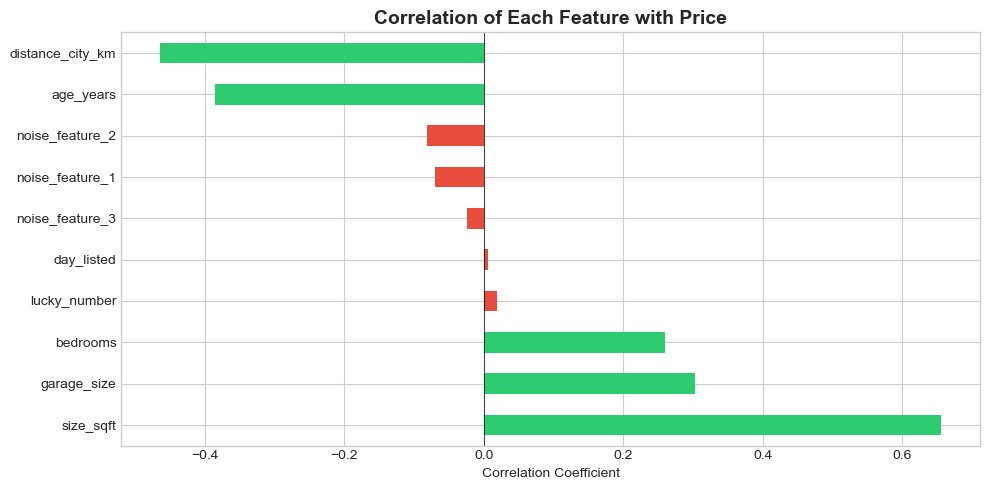

🟢 Green = Likely useful features
🔴 Red = Likely noise features


In [4]:
# Correlation with price — which features seem important?
correlations = df.corr()['price'].drop('price').sort_values(ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if abs(c) > 0.15 else '#e74c3c' for c in correlations]
correlations.plot(kind='barh', color=colors)
plt.title('Correlation of Each Feature with Price', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('🟢 Green = Likely useful features')
print('🔴 Red = Likely noise features')

**👆 Notice:** The real features (size, bedrooms, garage, age, distance) have strong correlations.  
The noise features have correlations near zero. But will our models be smart enough to ignore the noise?

##  Section 4: Train/Test Split & Scaling

**Why split?** To detect overfitting!  
**Why scale?** Ridge and Lasso penalties depend on coefficient SIZE — features must be on same scale.

In [5]:
# Separate features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

print(f'Features: {list(X.columns)}')
print(f'Target: price')
print(f'\nX shape: {X.shape}  (200 samples, 10 features)')
print(f'y shape: {y.shape}')

Features: ['size_sqft', 'bedrooms', 'age_years', 'distance_city_km', 'garage_size', 'noise_feature_1', 'noise_feature_2', 'noise_feature_3', 'day_listed', 'lucky_number']
Target: price

X shape: (200, 10)  (200 samples, 10 features)
y shape: (200,)


In [6]:
# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set:     {X_test.shape[0]} samples')

Training set: 160 samples
Test set:     40 samples


In [7]:
# IMPORTANT: Scale the features
# Ridge/Lasso penalize coefficients — if features are on different scales,
# the penalty is unfair (larger scale = larger coefficient = more penalty)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # Fit on train, transform train
X_test_scaled = scaler.transform(X_test)          # Only transform test (NO fit!)

# Convert back to DataFrame for readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print('✅ Features scaled!')
print('\nBefore scaling (first row):')
print(X_train.iloc[0].to_dict())
print('\nAfter scaling (first row):')
print(X_train_scaled.iloc[0].round(3).to_dict())

✅ Features scaled!

Before scaling (first row):
{'size_sqft': 506.21554269955357, 'bedrooms': 3.0, 'age_years': 25.354918099752048, 'distance_city_km': 11.404821604590996, 'garage_size': 0.0, 'noise_feature_1': 1.531688801240915, 'noise_feature_2': -0.5509481144654271, 'noise_feature_3': -1.6010192977017523, 'day_listed': 4.0, 'lucky_number': 35.0}

After scaling (first row):
{'size_sqft': -2.048, 'bedrooms': -0.022, 'age_years': 0.447, 'distance_city_km': 0.282, 'garage_size': -1.343, 'noise_feature_1': 1.671, 'noise_feature_2': -0.648, 'noise_feature_3': -1.581, 'day_listed': -0.028, 'lucky_number': -0.582}


###  CRITICAL POINT :
- We **fit** the scaler on **training data only**
- We **transform** both train and test
- If you fit on test data too → **data leakage** → fake good results!

## Section 5: Baseline — Plain Linear Regression (No Regularization)

Let's first see what happens WITHOUT any regularization.

In [10]:
# Fit plain Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = lr.predict(X_train_scaled)
y_test_pred_lr = lr.predict(X_test_scaled)

# Metrics
print('='*50)
print('📊 LINEAR REGRESSION (No Regularization)')
print('='*50)
print(f'\nTraining R² Score: {r2_score(y_train, y_train_pred_lr):.4f}')
print(f'Test R² Score:     {r2_score(y_test, y_test_pred_lr):.4f}')
#print(f'\nTraining RMSE: ${mean_squared_error(y_train, y_train_pred_lr, squared=False):,.0f}')
#print(f'Test RMSE:     ${mean_squared_error(y_test, y_test_pred_lr, squared=False):,.0f}')

gap = r2_score(y_train, y_train_pred_lr) - r2_score(y_test, y_test_pred_lr)
print(f'\n  Train-Test R² Gap: {gap:.4f}')
if gap > 0.05:
    print('   → This gap suggests some OVERFITTING!')

📊 LINEAR REGRESSION (No Regularization)

Training R² Score: 0.9374
Test R² Score:     0.8262

  Train-Test R² Gap: 0.1112
   → This gap suggests some OVERFITTING!


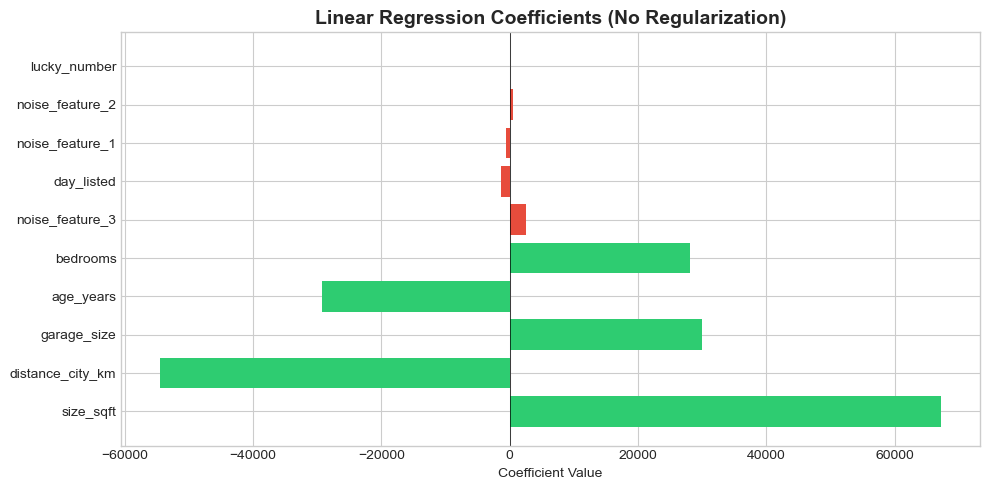

🟢 Green = Real features
🔴 Red = Noise features (should be ZERO but they are not!)


In [11]:
# Look at the coefficients — what did Linear Regression learn?
lr_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if 'noise' not in f and 'day' not in f and 'lucky' not in f 
          else '#e74c3c' for f in lr_coefs['Feature']]
plt.barh(lr_coefs['Feature'], lr_coefs['Coefficient'], color=colors)
plt.title('Linear Regression Coefficients (No Regularization)', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('🟢 Green = Real features')
print('🔴 Red = Noise features (should be ZERO but they are not!)')

### PROBLEM!
Notice the noise features have **non-zero coefficients**. Linear regression is fitting to noise!  
This is overfitting — the model thinks noise features matter. **Let's fix this with regularization.**

---
## Section 6: Ridge Regression (L2 Regularization)

**Ridge** adds a penalty = `alpha × Σ(coefficient²)`  
This SHRINKS all coefficients toward zero but never makes them exactly zero.

In [ ]:
# Fit Ridge Regression with alpha = 1.0
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

# price = B0 + B1*size_sqft + B2*bedrooms + B3*age_years + B4*distance_city + B5*garage_size + B6*noise_feature_1 + B7*noise_feature_2 + B8*noise_feature_3 + B9*day_listed + B10*lucky_number
# price = 50 + 0.5*size_sqft + 0.7*bedrooms + 1.2*age_years + B4*distance_city + B5*garage_size + B6*noise_feature_1 + B7*noise_feature_2 + B8*noise_feature_3 + B9*day_listed + B10*lucky_number

# Predictions
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_test_pred_ridge = ridge.predict(X_test_scaled)

# Metrics
print('='*50)
print('🏔️  RIDGE REGRESSION (alpha=1.0)')
print('='*50)
print(f'\nTraining R² Score: {r2_score(y_train, y_train_pred_ridge):.4f}')
print(f'Test R² Score:     {r2_score(y_test, y_test_pred_ridge):.4f}')
#print(f'\nTraining RMSE: ${mean_squared_error(y_train, y_train_pred_ridge, squared=False):,.0f}')
#print(f'Test RMSE:     ${mean_squared_error(y_test, y_test_pred_ridge, squared=False):,.0f}')

gap = r2_score(y_train, y_train_pred_ridge) - r2_score(y_test, y_test_pred_ridge)
print(f'\n📊 Train-Test R² Gap: {gap:.4f}')

🏔️  RIDGE REGRESSION (alpha=1.0)

Training R² Score: 0.9373
Test R² Score:     0.8276

📊 Train-Test R² Gap: 0.1098


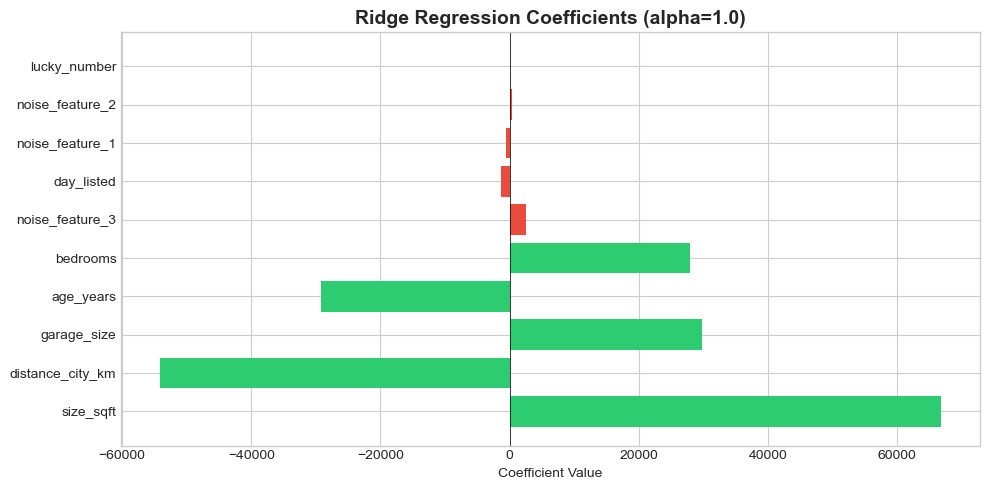

🟢 Green = Real features
🔴 Red = Noise features (smaller now but still NOT zero)


In [14]:
# Ridge coefficients
ridge_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ridge.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if 'noise' not in f and 'day' not in f and 'lucky' not in f 
          else '#e74c3c' for f in ridge_coefs['Feature']]
plt.barh(ridge_coefs['Feature'], ridge_coefs['Coefficient'], color=colors)
plt.title('Ridge Regression Coefficients (alpha=1.0)', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('🟢 Green = Real features')
print('🔴 Red = Noise features (smaller now but still NOT zero)')

** Notice:** Noise feature coefficients are **smaller** than before, but still not zero.  
Ridge SHRINKS but does NOT eliminate. Can Lasso do better?

---
## Section 7: Lasso Regression (L1 Regularization)

**Lasso** adds a penalty = `alpha × Σ|coefficient|`  
This can make coefficients **exactly ZERO** — automatic feature selection!

In [15]:
# Fit Lasso Regression with alpha = 1000
# Note: Lasso alpha needs to be larger because our target (price) is in hundreds of thousands
lasso = Lasso(alpha=1000)
lasso.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lasso = lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

# Metrics
print('='*50)
print('⚔️  LASSO REGRESSION (alpha=1000)')
print('='*50)
print(f'\nTraining R² Score: {r2_score(y_train, y_train_pred_lasso):.4f}')
print(f'Test R² Score:     {r2_score(y_test, y_test_pred_lasso):.4f}')
#print(f'\nTraining RMSE: ${mean_squared_error(y_train, y_train_pred_lasso, squared=False):,.0f}')
#print(f'Test RMSE:     ${mean_squared_error(y_test, y_test_pred_lasso, squared=False):,.0f}')

gap = r2_score(y_train, y_train_pred_lasso) - r2_score(y_test, y_test_pred_lasso)
print(f'\n📊 Train-Test R² Gap: {gap:.4f}')

⚔️  LASSO REGRESSION (alpha=1000)

Training R² Score: 0.9368
Test R² Score:     0.8316

📊 Train-Test R² Gap: 0.1052


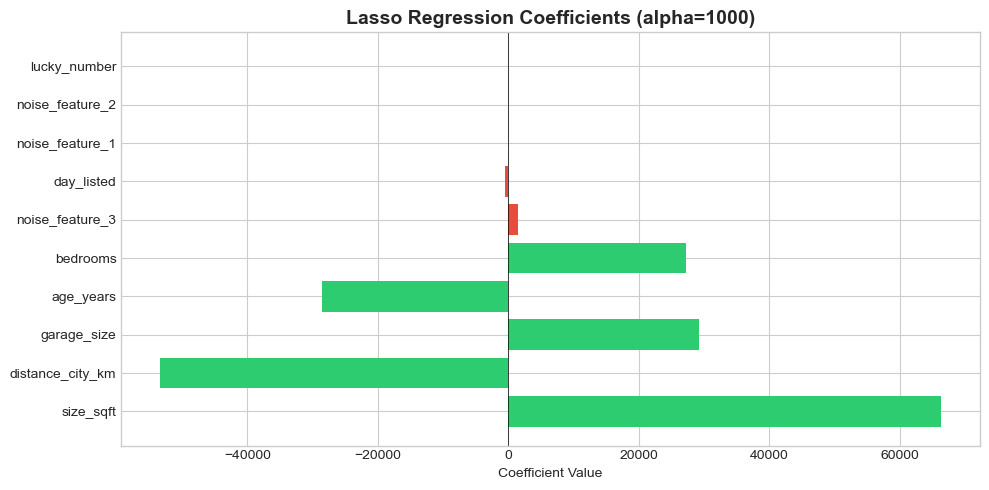


🔍 Features that Lasso KEPT (non-zero):
   ✅ size_sqft: 66,325
   ✅ distance_city_km: -53,312
   ✅ garage_size: 29,188
   ✅ age_years: -28,489
   ✅ bedrooms: 27,219
   ✅ noise_feature_3: 1,520
   ✅ day_listed: -509

🗑️  Features that Lasso REMOVED (set to zero):
   ❌ noise_feature_1: -0
   ❌ noise_feature_2: 0
   ❌ lucky_number: 0


In [16]:
# Lasso coefficients — THE MAGIC MOMENT!
lasso_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 5))
colors = ['#2ecc71' if 'noise' not in f and 'day' not in f and 'lucky' not in f 
          else '#e74c3c' for f in lasso_coefs['Feature']]
plt.barh(lasso_coefs['Feature'], lasso_coefs['Coefficient'], color=colors)
plt.title('Lasso Regression Coefficients (alpha=1000)', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('\n🔍 Features that Lasso KEPT (non-zero):')
kept = lasso_coefs[lasso_coefs['Coefficient'] != 0]
for _, row in kept.iterrows():
    print(f"   ✅ {row['Feature']}: {row['Coefficient']:,.0f}")

print(f'\n🗑️  Features that Lasso REMOVED (set to zero):')
removed = lasso_coefs[lasso_coefs['Coefficient'] == 0]
for _, row in removed.iterrows():
    print(f"   ❌ {row['Feature']}: {row['Coefficient']:.0f}")

### 🎯 THIS IS THE KEY TAKEAWAY!

**Lasso automatically removed the noise features** by setting their coefficients to exactly zero!  
It figured out which features are real and which are garbage — without us telling it!  
This is called **automatic feature selection** and it's Lasso's superpower.

---
## Section 8: Side-by-Side Comparison

In [17]:
# Compare all three models' coefficients
comparison = pd.DataFrame({
    'Feature': X.columns,
    'Linear Reg': lr.coef_.round(0),
    'Ridge (L2)': ridge.coef_.round(0),
    'Lasso (L1)': lasso.coef_.round(0)
})

# Add a column showing if feature is real or noise
comparison['Type'] = comparison['Feature'].apply(
    lambda f: '✅ REAL' if 'noise' not in f and 'day' not in f and 'lucky' not in f else '❌ NOISE'
)

comparison = comparison.sort_values('Linear Reg', key=abs, ascending=False)
print('\n📊 COEFFICIENT COMPARISON')
print('='*75)
print(comparison.to_string(index=False))


📊 COEFFICIENT COMPARISON
         Feature  Linear Reg  Ridge (L2)  Lasso (L1)    Type
       size_sqft     67195.0     66784.0     66325.0  ✅ REAL
distance_city_km    -54433.0    -54081.0    -53312.0  ✅ REAL
     garage_size     30026.0     29837.0     29188.0  ✅ REAL
       age_years    -29258.0    -29150.0    -28489.0  ✅ REAL
        bedrooms     28110.0     27952.0     27219.0  ✅ REAL
 noise_feature_3      2515.0      2467.0      1520.0 ❌ NOISE
      day_listed     -1392.0     -1411.0      -509.0 ❌ NOISE
 noise_feature_1      -597.0      -632.0        -0.0 ❌ NOISE
 noise_feature_2       433.0       418.0         0.0 ❌ NOISE
    lucky_number        40.0        81.0         0.0 ❌ NOISE


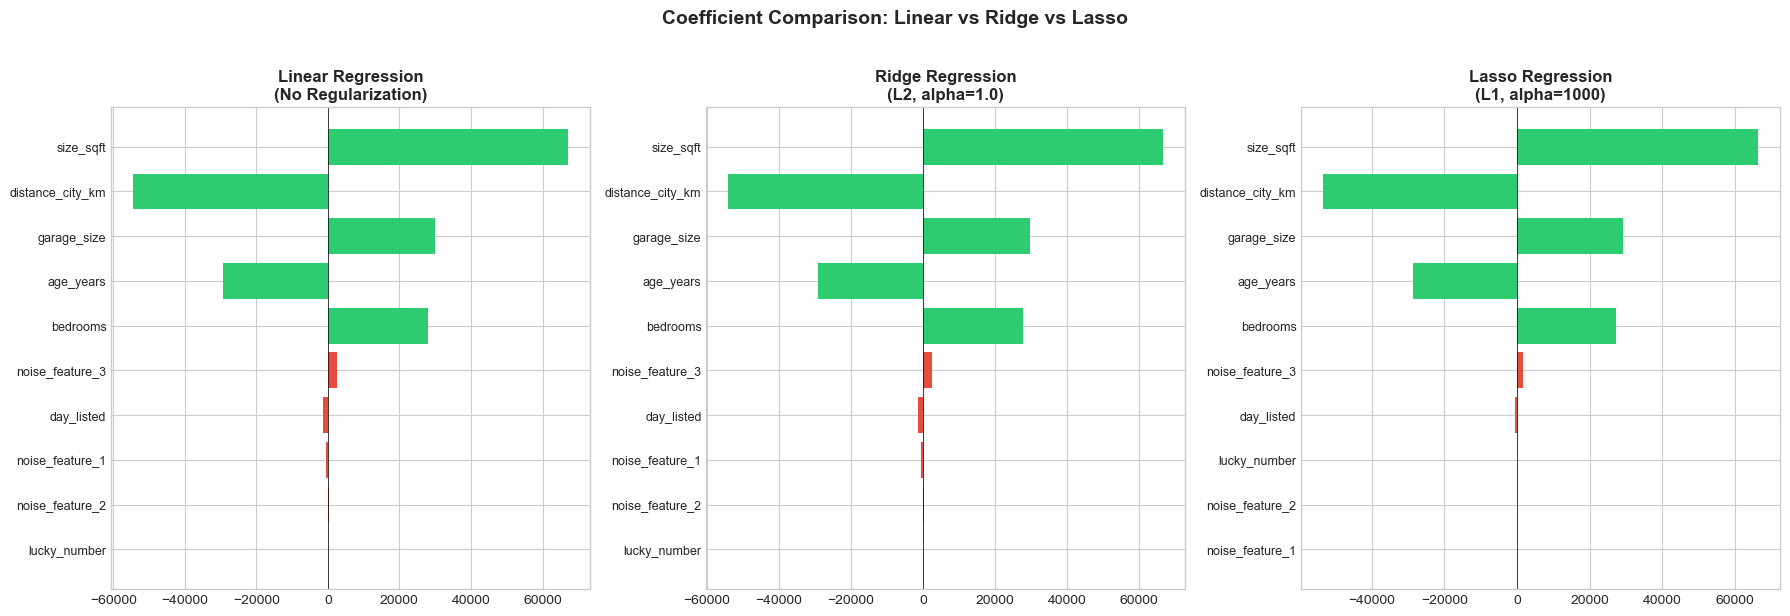

In [18]:
# Visual comparison of coefficients
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models_data = [
    ('Linear Regression\n(No Regularization)', lr.coef_),
    ('Ridge Regression\n(L2, alpha=1.0)', ridge.coef_),
    ('Lasso Regression\n(L1, alpha=1000)', lasso.coef_)
]

for ax, (title, coefs) in zip(axes, models_data):
    sorted_idx = np.argsort(np.abs(coefs))[::-1]
    features_sorted = X.columns[sorted_idx]
    coefs_sorted = coefs[sorted_idx]
    
    colors = ['#2ecc71' if 'noise' not in f and 'day' not in f and 'lucky' not in f 
              else '#e74c3c' for f in features_sorted]
    ax.barh(range(len(coefs_sorted)), coefs_sorted, color=colors)
    ax.set_yticks(range(len(features_sorted)))
    ax.set_yticklabels(features_sorted, fontsize=9)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linewidth=0.5)
    ax.invert_yaxis()

plt.suptitle('Coefficient Comparison: Linear vs Ridge vs Lasso', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# Performance comparison
print('\n📊 PERFORMANCE COMPARISON')
print('='*70)
print(f'{"Model":<30} {"Train R²":>10} {"Test R²":>10} {"Gap":>8} {"Test RMSE":>12}')
print('-'*70)

models = [
    ('Linear Regression', y_train_pred_lr, y_test_pred_lr),
    ('Ridge (alpha=1.0)', y_train_pred_ridge, y_test_pred_ridge),
    ('Lasso (alpha=1000)', y_train_pred_lasso, y_test_pred_lasso),
]

for name, y_tr, y_te in models:
    tr_r2 = r2_score(y_train, y_tr)
    te_r2 = r2_score(y_test, y_te)
    gap = tr_r2 - te_r2
    #rmse = mean_squared_error(y_test, y_te, squared=False)
    print(f'{name:<30} {tr_r2:>10.4f} {te_r2:>10.4f} {gap:>8.4f} {"$":>3}')

print('\n💡 Smaller gap = less overfitting = better generalization!')


📊 PERFORMANCE COMPARISON
Model                            Train R²    Test R²      Gap    Test RMSE
----------------------------------------------------------------------
Linear Regression                  0.9374     0.8262   0.1112   $
Ridge (alpha=1.0)                  0.9373     0.8276   0.1098   $
Lasso (alpha=1000)                 0.9368     0.8316   0.1052   $

💡 Smaller gap = less overfitting = better generalization!


---
## Section 9: What Happens When We Change Alpha?

Alpha controls the **strength** of regularization:  
- `alpha = 0` → No regularization (plain linear regression)  
- `alpha = small` → Mild penalty  
- `alpha = large` → Strong penalty → simpler model  

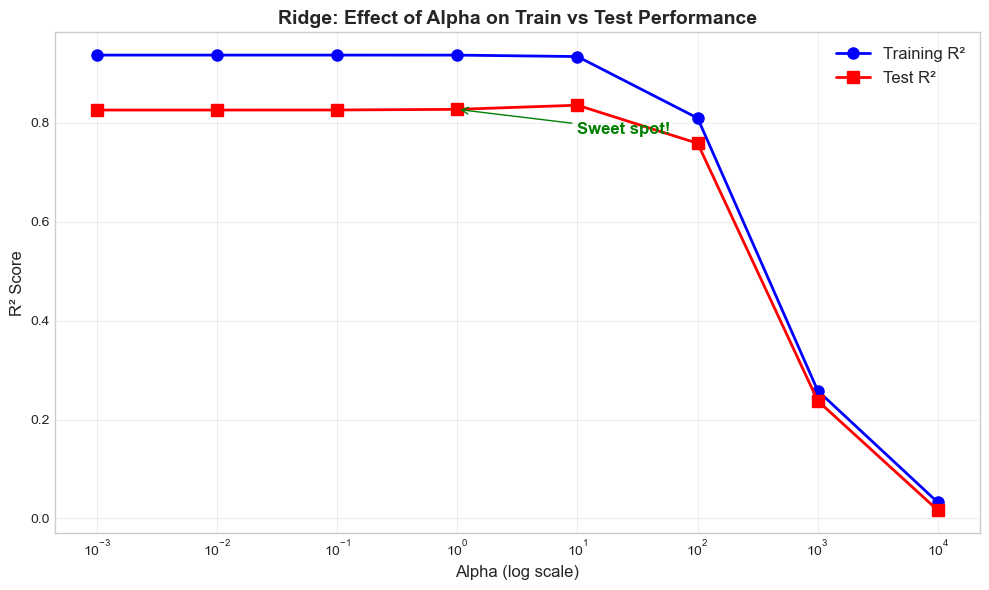

💡 As alpha increases:
   → Training score goes DOWN (model gets simpler)
   → Test score first goes UP then DOWN
   → The gap between train and test SHRINKS
   → Too much alpha = UNDERFITTING!


In [21]:
# Test different alpha values for Ridge
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
ridge_train_scores = []
ridge_test_scores = []

for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    ridge_train_scores.append(r2_score(y_train, model.predict(X_train_scaled)))
    ridge_test_scores.append(r2_score(y_test, model.predict(X_test_scaled)))

plt.figure(figsize=(10, 6))
plt.plot(alphas, ridge_train_scores, 'bo-', label='Training R²', linewidth=2, markersize=8)
plt.plot(alphas, ridge_test_scores, 'rs-', label='Test R²', linewidth=2, markersize=8)
plt.xscale('log')
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Ridge: Effect of Alpha on Train vs Test Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Add annotation
plt.annotate('Sweet spot!', xy=(1, ridge_test_scores[3]), 
            xytext=(10, ridge_test_scores[3]-0.05),
            arrowprops=dict(arrowstyle='->', color='green'),
            fontsize=12, color='green', fontweight='bold')
plt.tight_layout()
plt.show()

print('💡 As alpha increases:')
print('   → Training score goes DOWN (model gets simpler)')
print('   → Test score first goes UP then DOWN')
print('   → The gap between train and test SHRINKS')
print('   → Too much alpha = UNDERFITTING!')

In [22]:
# Test different alpha values for Lasso — watch features disappear!
lasso_alphas = [1, 10, 100, 500, 1000, 5000, 10000, 50000]
feature_counts = []
lasso_test_scores = []

print('⚔️  LASSO: Features removed at each alpha level')
print('='*60)

for alpha in lasso_alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    n_features = np.sum(model.coef_ != 0)
    test_r2 = r2_score(y_test, model.predict(X_test_scaled))
    feature_counts.append(n_features)
    lasso_test_scores.append(test_r2)
    
    active = [f for f, c in zip(X.columns, model.coef_) if c != 0]
    print(f'Alpha={alpha:>6} | Features kept: {n_features:>2}/10 | Test R²: {test_r2:.4f} | Active: {active}')

print('\n💡 As alpha increases, Lasso removes more and more features!')
print('   Too much alpha = even REAL features get removed = UNDERFITTING')

⚔️  LASSO: Features removed at each alpha level
Alpha=     1 | Features kept: 10/10 | Test R²: 0.8262 | Active: ['size_sqft', 'bedrooms', 'age_years', 'distance_city_km', 'garage_size', 'noise_feature_1', 'noise_feature_2', 'noise_feature_3', 'day_listed', 'lucky_number']
Alpha=    10 | Features kept: 10/10 | Test R²: 0.8262 | Active: ['size_sqft', 'bedrooms', 'age_years', 'distance_city_km', 'garage_size', 'noise_feature_1', 'noise_feature_2', 'noise_feature_3', 'day_listed', 'lucky_number']
Alpha=   100 | Features kept:  9/10 | Test R²: 0.8267 | Active: ['size_sqft', 'bedrooms', 'age_years', 'distance_city_km', 'garage_size', 'noise_feature_1', 'noise_feature_2', 'noise_feature_3', 'day_listed']
Alpha=   500 | Features kept:  8/10 | Test R²: 0.8288 | Active: ['size_sqft', 'bedrooms', 'age_years', 'distance_city_km', 'garage_size', 'noise_feature_1', 'noise_feature_3', 'day_listed']
Alpha=  1000 | Features kept:  7/10 | Test R²: 0.8316 | Active: ['size_sqft', 'bedrooms', 'age_years', 

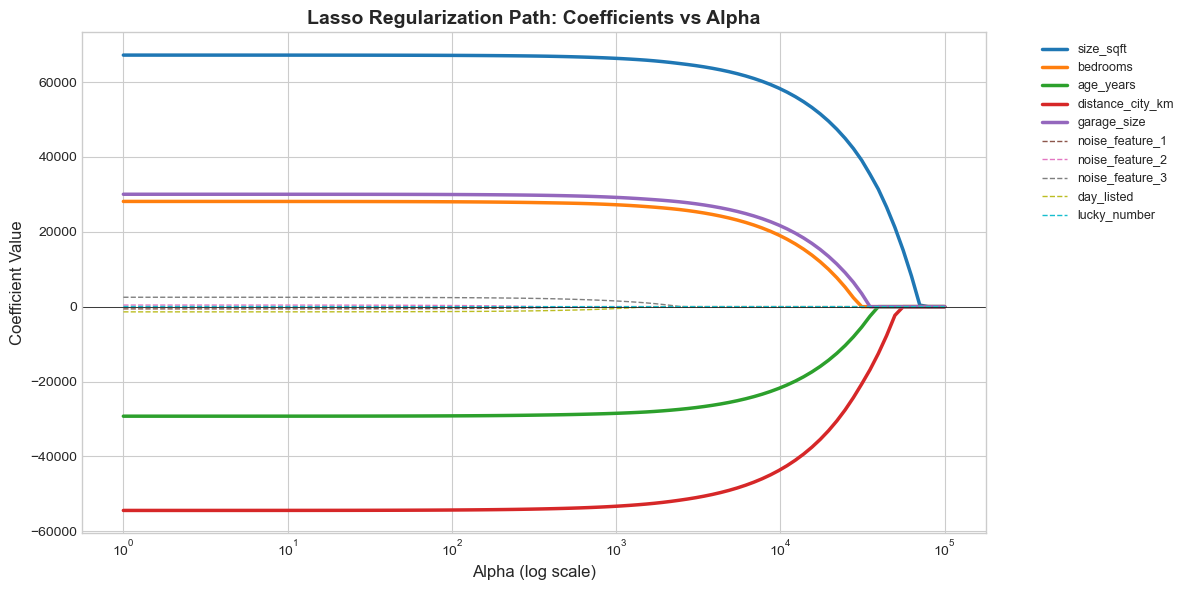

💡 Solid lines = REAL features, Dashed lines = NOISE features
   Notice: Noise features hit zero FIRST (at lower alpha)
   Real features survive much longer before being zeroed out


In [23]:
# Visualize: How coefficients shrink with increasing alpha
alphas_range = np.logspace(0, 5, 100)
coefs_path = []

for alpha in alphas_range:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    coefs_path.append(model.coef_)

coefs_path = np.array(coefs_path)

plt.figure(figsize=(12, 6))
for i, feature in enumerate(X.columns):
    is_noise = 'noise' in feature or 'day' in feature or 'lucky' in feature
    style = '--' if is_noise else '-'
    width = 1 if is_noise else 2.5
    plt.plot(alphas_range, coefs_path[:, i], style, linewidth=width, label=feature)

plt.xscale('log')
plt.xlabel('Alpha (log scale)', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Lasso Regularization Path: Coefficients vs Alpha', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.axhline(y=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('💡 Solid lines = REAL features, Dashed lines = NOISE features')
print('   Notice: Noise features hit zero FIRST (at lower alpha)')
print('   Real features survive much longer before being zeroed out')

---
## Section 10: Actual vs Predicted Prices

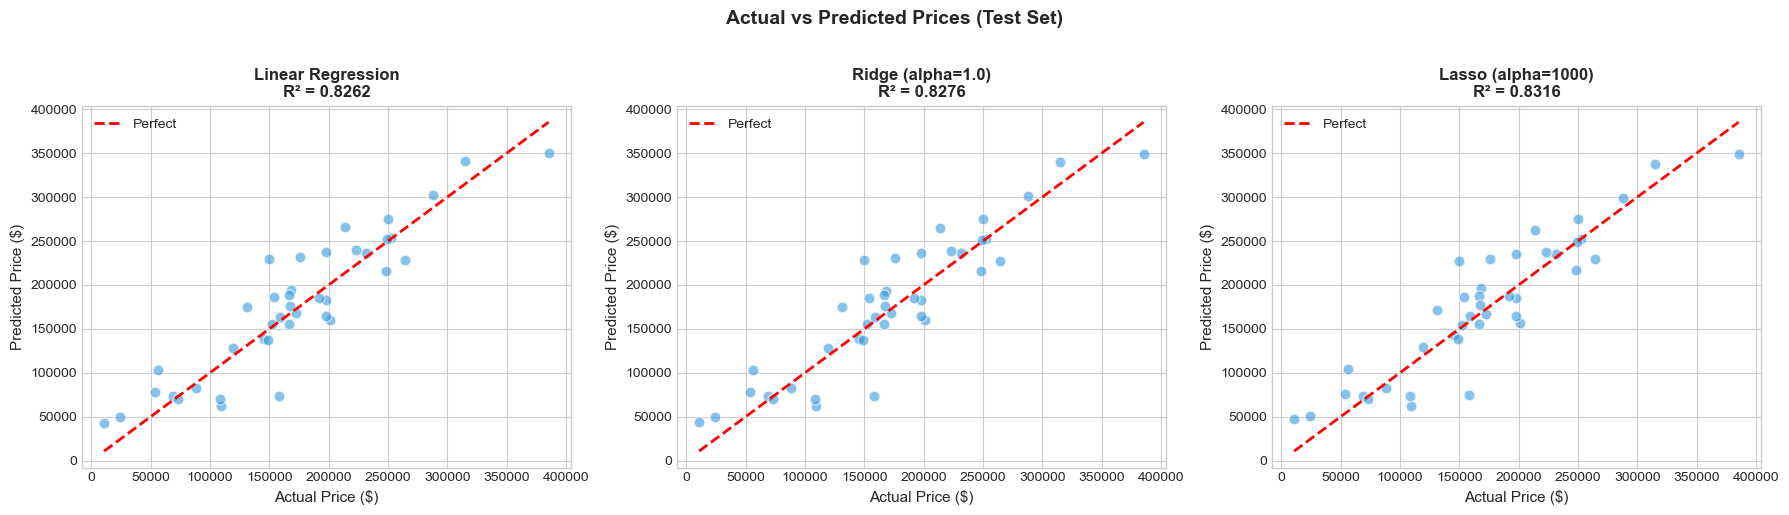

💡 Points closer to the red dashed line = better predictions!


In [24]:
# Scatter plot: Actual vs Predicted for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

predictions = [
    ('Linear Regression', y_test_pred_lr),
    ('Ridge (alpha=1.0)', y_test_pred_ridge),
    ('Lasso (alpha=1000)', y_test_pred_lasso)
]

for ax, (name, y_pred) in zip(axes, predictions):
    ax.scatter(y_test, y_pred, alpha=0.6, color='#3498db', edgecolors='white', s=60)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
    
    ax.set_xlabel('Actual Price ($)', fontsize=11)
    ax.set_ylabel('Predicted Price ($)', fontsize=11)
    r2 = r2_score(y_test, y_pred)
    ax.set_title(f'{name}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)

plt.suptitle('Actual vs Predicted Prices (Test Set)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('💡 Points closer to the red dashed line = better predictions!')

---
## ✅ Section 11: Final Summary

| | Linear Regression | Ridge (L2) | Lasso (L1) |
|---|---|---|---|
| **Penalty** | None | α × Σ(coef²) | α × Σ\|coef\| |
| **Shrinks coefficients?** | No | Yes, toward zero | Yes, toward zero |
| **Makes coefficients exactly 0?** | No | No | ✅ Yes! |
| **Feature selection?** | No | No | ✅ Yes! |
| **When to use?** | No overfitting | All features matter | Many irrelevant features |
| **Alpha = 0** | Same as this | Same as this | Same as this |
| **Alpha = ∞** | N/A | All coefficients → 0 | All coefficients = 0 |

###  Homework / Practice:

1. Try changing `alpha` values and see how results change
2. Try removing the noise features manually and compare with Lasso's automatic selection
3. Try `ElasticNet` from sklearn — it combines Ridge + Lasso!
4. Load a real dataset (like Boston Housing or California Housing) and apply all three models



---
